In [1]:
%matplotlib inline
import os,sys,re
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cross_validation import train_test_split
read_path = '/home/mckc/Face oNN/Complete Face Data/'
#read_path = '/home/mckc/Face oNN/Complete Face Data/'
save_path = '/home/mckc/new/'
os.chdir(read_path)
os.getcwd()
folders = os.listdir(os.getcwd())

In [2]:
def PCA_comp(data):
    from time import *
    from sklearn.decomposition import PCA
    n_components = 150
    
    h,w = 96,96

    print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, image_data.shape[0]))
    t0 = time()
    pca = PCA(n_components=n_components, whiten=True).fit(images_geq)
    print("done in %0.3fs" % (time() - t0))

    #eigenfaces = pca.components_.reshape((n_components, h, w))

    print("Projecting the input data on the eigenfaces orthonormal basis")
    t0 = time()
    X = pca.transform(data)
    print X.shape
    print("done in %0.3fs" % (time() - t0))
    return(X)
#K-mediods file
import numpy as np
import random

def kMedoids(D, k, tmax=100):
    # determine dimensions of distance matrix D
    m, n = D.shape

    if k > n:
        raise Exception('too many medoids')
    # randomly initialize an array of k medoid indices
    M = np.arange(n)
    np.random.shuffle(M)
    M = np.sort(M[:k])

    # create a copy of the array of medoid indices
    Mnew = np.copy(M)

    # initialize a dictionary to represent clusters
    C = {}
    for t in xrange(tmax):
        # determine clusters, i. e. arrays of data indices
        J = np.argmin(D[:,M], axis=1)
        for kappa in range(k):
            C[kappa] = np.where(J==kappa)[0]
        # update cluster medoids
        for kappa in range(k):
            J = np.mean(D[np.ix_(C[kappa],C[kappa])],axis=1)
            j = np.argmin(J)
            Mnew[kappa] = C[kappa][j]
        np.sort(Mnew)
        # check for convergence
        if np.array_equal(M, Mnew):
            break
        M = np.copy(Mnew)
    else:
        # final update of cluster memberships
        J = np.argmin(D[:,M], axis=1)
        for kappa in range(k):
            C[kappa] = np.where(J==kappa)[0]

# return results
    return M, C

<ipython-input-2-13e1dc72abe0>:1: SyntaxWarning: import * only allowed at module level
  def PCA_comp(data):


himanshu
Extracting the top 150 eigenfaces from 76 faces
done in 0.021s
Projecting the input data on the eigenfaces orthonormal basis
(76, 76)
done in 0.003s


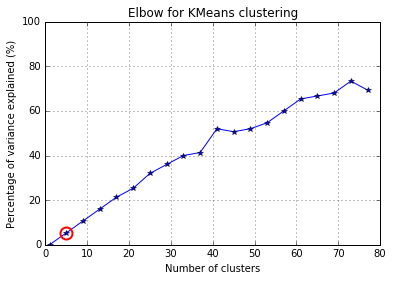

In [157]:
folder = folders[86]
print(folder)

import cv2
from cv2 import resize
from skimage import exposure
from skimage import exposure
from skimage.morphology import disk
from skimage.filters import rank
selem = disk(30)
size = []
images_geq = []
images_eql = []
images = []

os.chdir(read_path+folder)
files = os.listdir(read_path+folder)
#files = os.listdir(read_path)

for i in files:
    image = resize(cv2.imread(i,0),(96,96))
    #image = cv2.imread(i,0)
    # Global equalize
    image_g_eq = exposure.equalize_hist(image)

    # Equalization
    image_eql = rank.equalize(image, selem=selem)
    images.append(image)
    images_geq.append(image_g_eq)
    images_eql.append(image_eql)
    size.append(image.shape[0])
size = np.array(size)
image_data = np.array(images).reshape(-1,9216)
images_geq = np.array(images_geq).reshape(-1,9216)
images_eql = np.array(images_eql).reshape(-1,9216)
X  = PCA_comp(images_geq)
X.shape

from scipy.cluster.vq import kmeans
from scipy.spatial.distance import cdist,pdist

##### cluster data into K=1..20 clusters #####
K_MAX = 80
KK = range(1,K_MAX,4)

KM = [kmeans(X[:,:],k,iter=50) for k in KK]
centroids = [cent for (cent,var) in KM]
D_k = [cdist(X[:,:], cent, 'euclidean') for cent in centroids]
cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]

tot_withinss = [sum(d**2) for d in dist]  # Total within-cluster sum of squares
totss = sum(pdist(X)**2)/X.shape[0]       # The total sum of squares
betweenss = totss - tot_withinss      

##### plots #####
kIdx = 1        # K=10
# elbow curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(KK, betweenss/totss*100, 'b*-')
ax.plot(KK[kIdx], betweenss[kIdx]/totss*100, marker='o', markersize=12, 
    markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
ax.set_ylim((0,100))
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Percentage of variance explained (%)')
plt.title('Elbow for KMeans clustering')

In [156]:
from sklearn.metrics.pairwise import pairwise_distances
D = pairwise_distances(X, metric='euclidean')

# split into 2 clusters
M, C = kMedoids(D, 45)
cleaned = image_data[M,].reshape(-1,96,96)

os.chdir(save_path+folder)
import scipy.misc
for i in range(cleaned.shape[0]):
    scipy.misc.toimage(cleaned[i]).save(str(folder+'_'+str(i)) +'.jpg')
os.chdir(read_path)